# Introduction

In [67]:
import pyspark
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Current Spark settings
for s in settings:
    print(s)
executor_memory = conf.get("spark.executor.memory")
executor_cores = conf.get("spark.executor.cores")
default_parallelism = conf.get("spark.default.parallelism")

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[*]'),
('spark.app.name', 'MusicRecommender')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

('spark.app.submitTime', '1714516544819')
('spark.master', 'local[*]')
('spark.submit.pyFiles', '')
('spark.submit.deployMode', 'client')
('spark.app.name', 'MusicRecommender')
('spark.ui.showConsoleProgress', 'true')


In [69]:
# Config Variables
user = "hadoop"
HDFS_DATA = f"hdfs:///user/{user}/data"
partitions = 10

In [176]:
def load_file_from_hdfs(file_name):
    hdfs_path = f"{HDFS_DATA}/{file_name}"
    return spark.read.csv(hdfs_path, sep="\t", header=False, inferSchema=True)


train_files = [f"train/train_{i}.txt" for i in range(partitions)]
test_files = [f"test/test_{i}.txt" for i in range(partitions)]

train_data = None
test_data = None

for i, file in enumerate(train_files):
    train_partition_df = load_file_from_hdfs(file)
    train_partition_df = train_partition_df.withColumnsRenamed({"_c0": "user_id", "_c1": "song_id", "_c2": "rating"})
    # Add a partition column
    train_partition_df = train_partition_df.withColumn("partition_id", F.lit(i))
    # Comhbine all the partitions
    if train_data is None:
        train_data = train_partition_df
    else:
        train_data = train_data.union(train_partition_df)
    
for i, file in enumerate(test_files):
    test_partition_df = load_file_from_hdfs(file)
    test_partition_df = test_partition_df.withColumnsRenamed({"_c0": "user_id", "_c1": "song_id", "_c2": "rating"})
    # Add a partition column
    test_partition_df = test_partition_df.withColumn("partition_id", F.lit(i))
    # Comhbine all the partitions
    if test_data is None:
        test_data = test_partition_df
    else:
        test_data = test_data.union(test_partition_df)
        
train_data.cache()
test_data.cache()
    

DataFrame[user_id: int, song_id: int, rating: int, partition_id: int]

In [178]:
def perform_eda(df):
    df.summary().show()
    
    ratings = df.count()
    print("Number of ratings: ", ratings)
    
    users = df.groupBy("user_id").count()
    print("Number of unique users: ", len(users.collect()))

    songs = df.groupBy("song_id").count()
    print("Number of unique songs: ", len(songs.collect()))

    return df

def plot_user_ratings_distribution(df, ax, partition_id):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # define a list of colors

    user_rating_counts = df.groupBy("user_id").count()
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "user_count")
    user_rating_counts = user_rating_counts.sort("rating_count")
    
    # print user_rating_counts statistics
    print(f'Partition {partition_id} user_rating_counts statistics:')
    print(user_rating_counts.summary().show())
    
    user_rating_counts = user_rating_counts.toPandas()
    
    # plot a violin plot
    sns.violinplot(data=user_rating_counts['rating_count'], ax=ax, color=colors[partition_id % len(colors)], label=f'Partition {partition_id}')
    ax.set_title(f'Partition {partition_id}')
    ax.set_xlabel('Users')
    ax.set_ylabel('Number of Ratings')
    ax.set_ylim(0, 140000)

# Training

In [180]:
# Show the first 5 rows of the train data
train_data.show(5)

+-------+-------+------+------------+
|user_id|song_id|rating|partition_id|
+-------+-------+------+------------+
|      0|    166|     5|           0|
|      0|   2245|     4|           0|
|      0|   3637|     4|           0|
|      0|   5580|     4|           0|
|      0|   5859|     4|           0|
+-------+-------+------+------------+
only showing top 5 rows



+-------+-----------------+-----------------+------------------+------------------+
|summary|          user_id|          song_id|            rating|      partition_id|
+-------+-----------------+-----------------+------------------+------------------+
|  count|        699640226|        699640226|         699640226|         699640226|
|   mean|911843.3316849952|68281.05670398088|3.1572554120122875| 4.064555439097923|
| stddev|525979.2523050717|39466.04269546232|1.6017787062461935|2.6238735905702693|
|    min|                0|                0|                 1|                 0|
|    25%|           455991|            34384|                 1|                 2|
|    50%|           911186|            68311|                 3|                 4|
|    75%|          1366824|           102357|                 5|                 6|
|    max|          1823178|           136735|                 5|                 9|
+-------+-----------------+-----------------+------------------+------------

Number of unique users:  1823179


Number of unique songs:  136736


Number of ratings:  699640226


Ratings per user distribution: 
  summary              count
0   count            1823179
1    mean  383.7474137207592
2  stddev  868.7340376364643
3     min                 20
4     max             131523


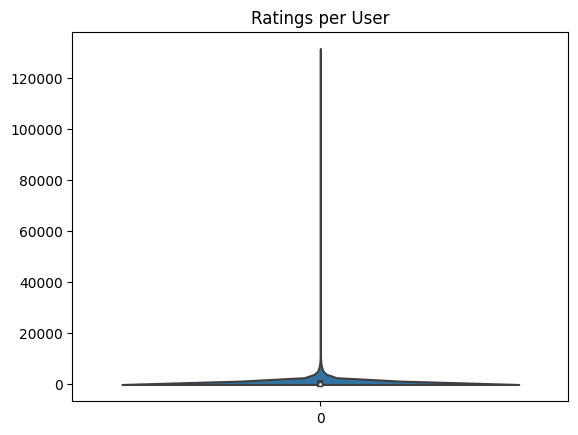

+-------+------------------+------------------+------------------+------------+
|summary|           user_id|           song_id|            rating|partition_id|
+-------+------------------+------------------+------------------+------------+
|  count|          76344627|          76344627|          76344627|    76344627|
|   mean|100040.94482474844| 68279.70831871378|3.1534895834909245|         0.0|
| stddev| 57753.04973969481|39461.312338210184| 1.599535981362968|         0.0|
|    min|                 0|                 0|                 1|           0|
|    25%|             49825|             34391|                 1|           0|
|    50%|            100133|             68311|                 3|           0|
|    75%|            149813|            102348|                 5|           0|
|    max|            199999|            136735|                 5|           0|
+-------+------------------+------------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76344627
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean         381.723135
2  stddev  809.3976703102835
3     min                 20
4     max              71009


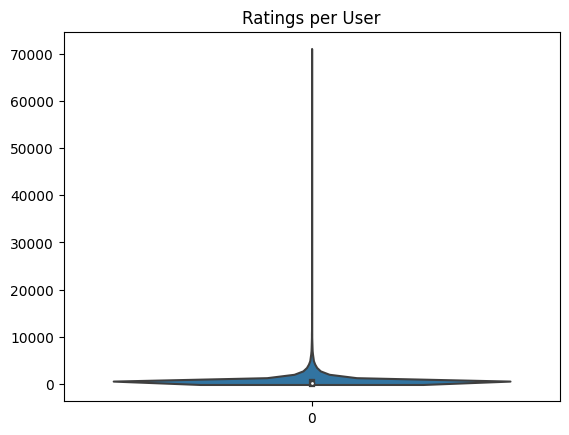

+-------+------------------+-----------------+------------------+------------+
|summary|           user_id|          song_id|            rating|partition_id|
+-------+------------------+-----------------+------------------+------------+
|  count|          76742463|         76742463|          76742463|    76742463|
|   mean|299958.76480113756|68275.80856346765|3.1557116038874073|         1.0|
| stddev|  57841.7747198173|39465.77011167411|1.6052135642346348|         0.0|
|    min|            200000|                0|                 1|           1|
|    25%|            249920|            34380|                 1|           1|
|    50%|            299697|            68285|                 3|           1|
|    75%|            349906|           102348|                 5|           1|
|    max|            399999|           136735|                 5|           1|
+-------+------------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76742463
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean         383.712315
2  stddev  865.3380083595573
3     min                 20
4     max              72816


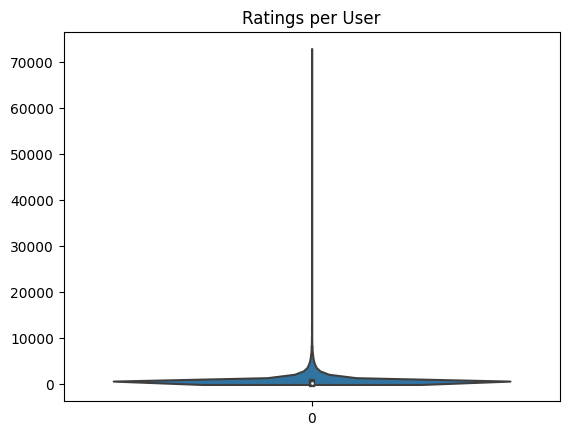

+-------+-----------------+-----------------+------------------+------------+
|summary|          user_id|          song_id|            rating|partition_id|
+-------+-----------------+-----------------+------------------+------------+
|  count|         76909821|         76909821|          76909821|    76909821|
|   mean|499739.8884490057|68282.31141463715|3.1449157839022925|         2.0|
| stddev|57941.97198096776|39461.15757604169|1.6034984369805134|         0.0|
|    min|           400000|                0|                 1|           2|
|    25%|           449252|            34394|                 1|           2|
|    50%|           499600|            68313|                 3|           2|
|    75%|           550154|           102348|                 5|           2|
|    max|           599999|           136735|                 5|           2|
+-------+-----------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76909821
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean         384.549105
2  stddev  895.9137386410782
3     min                 20
4     max             131523


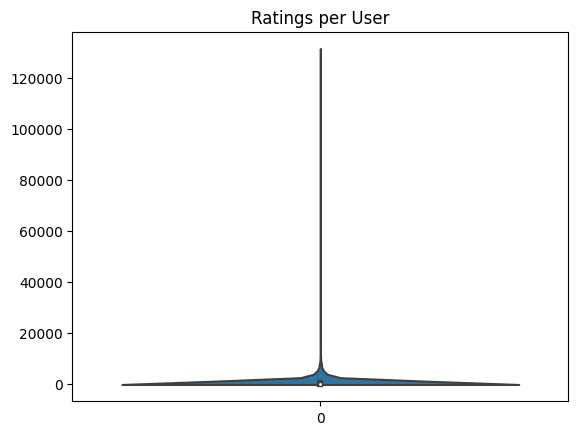

+-------+-----------------+-----------------+------------------+------------+
|summary|          user_id|          song_id|            rating|partition_id|
+-------+-----------------+-----------------+------------------+------------+
|  count|         76925707|         76925707|          76925707|    76925707|
|   mean|700329.3263218238|68279.35095131463|3.1566973833597656|         3.0|
| stddev|57808.51532308054|39465.20625044262|1.5988003024146724|         0.0|
|    min|           600000|                0|                 1|           3|
|    25%|           650148|            34382|                 1|           3|
|    50%|           700348|            68307|                 3|           3|
|    75%|           750572|           102350|                 5|           3|
|    max|           799999|           136735|                 5|           3|
+-------+-----------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76925707
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean         384.628535
2  stddev  887.8189138956628
3     min                 20
4     max             105058


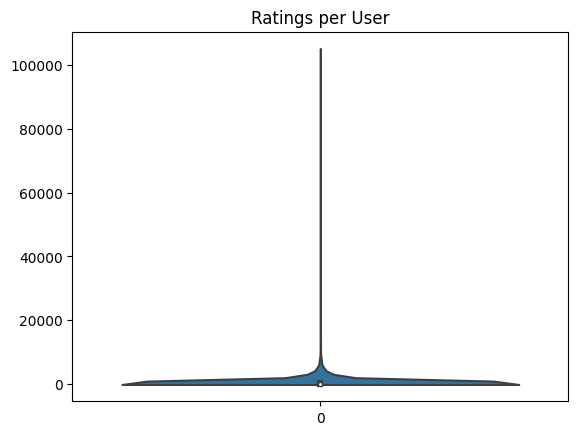

+-------+-----------------+-----------------+------------------+------------+
|summary|          user_id|          song_id|            rating|partition_id|
+-------+-----------------+-----------------+------------------+------------+
|  count|         76915994|         76915994|          76915994|    76915994|
|   mean|899946.1903731362|68282.11993703156| 3.153008904753932|         4.0|
| stddev|57768.04946931683|39469.84922439781|1.6014705065268102|         0.0|
|    min|           800000|                0|                 1|           4|
|    25%|           849905|            34380|                 1|           4|
|    50%|           899973|            68310|                 3|           4|
|    75%|           949935|           102361|                 5|           4|
|    max|           999999|           136735|                 5|           4|
+-------+-----------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76915994
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean          384.57997
2  stddev  896.9600720554115
3     min                 20
4     max              89412


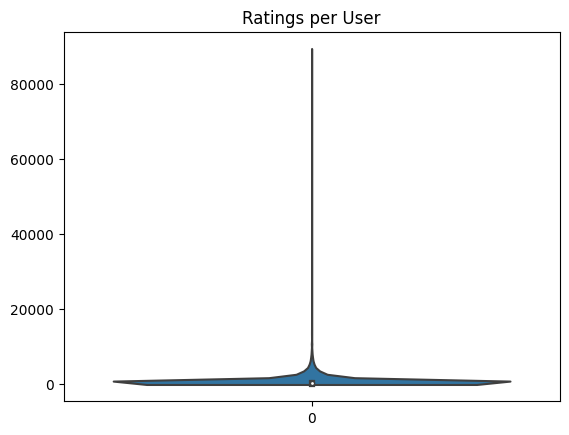

+-------+------------------+-----------------+------------------+------------+
|summary|           user_id|          song_id|            rating|partition_id|
+-------+------------------+-----------------+------------------+------------+
|  count|          76819181|         76819181|          76819181|    76819181|
|   mean|1100095.7076421578|68283.96638652006|3.1616862460431596|         5.0|
| stddev| 57600.52632503444|39470.34210076721| 1.602394384098761|         0.0|
|    min|           1000000|                0|                 1|           5|
|    25%|           1050108|            34381|                 1|           5|
|    50%|           1100356|            68310|                 3|           5|
|    75%|           1149860|           102374|                 5|           5|
|    max|           1199999|           136735|                 5|           5|
+-------+------------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76819181
Ratings per user distribution: 
  summary             count
0   count            200000
1    mean        384.095905
2  stddev  874.567044053687
3     min                20
4     max             76229


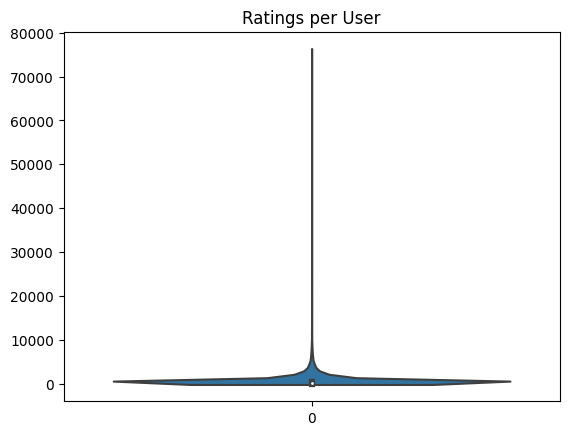

+-------+-----------------+-----------------+------------------+------------+
|summary|          user_id|          song_id|            rating|partition_id|
+-------+-----------------+-----------------+------------------+------------+
|  count|         76684534|         76684534|          76684534|    76684534|
|   mean|1299774.355541901|68282.05770080053|3.1588790250717307|         6.0|
| stddev|57661.08077205554|39468.41706142574| 1.602999906740885|         0.0|
|    min|          1200000|                0|                 1|           6|
|    25%|          1249755|            34380|                 1|           6|
|    50%|          1299719|            68312|                 3|           6|
|    75%|          1349513|           102374|                 5|           6|
|    max|          1399999|           136735|                 5|           6|
+-------+-----------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76684534
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean          383.42267
2  stddev  866.2192524176724
3     min                 20
4     max              87257


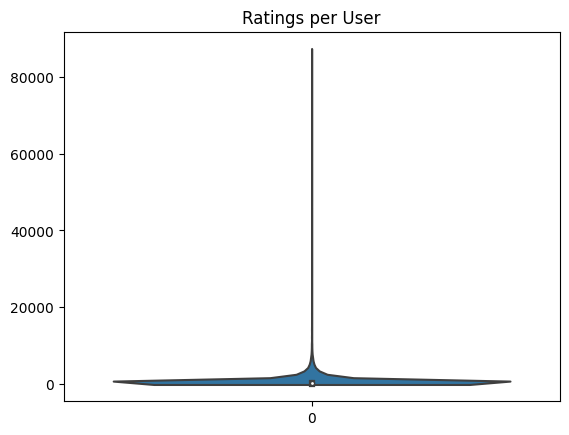

+-------+-----------------+-----------------+------------------+------------+
|summary|          user_id|          song_id|            rating|partition_id|
+-------+-----------------+-----------------+------------------+------------+
|  count|         76709916|         76709916|          76709916|    76709916|
|   mean|1500227.755400045|68283.66481444199|3.1710032898484726|         7.0|
| stddev|57882.25022926055|39467.82547262541|1.6011347289024478|         0.0|
|    min|          1400000|                0|                 1|           7|
|    25%|          1450139|            34388|                 1|           7|
|    50%|          1500324|            68313|                 3|           7|
|    75%|          1550592|           102365|                 5|           7|
|    max|          1599999|           136735|                 5|           7|
+-------+-----------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76709916
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean          383.54958
2  stddev  887.3535894860536
3     min                 20
4     max             106189


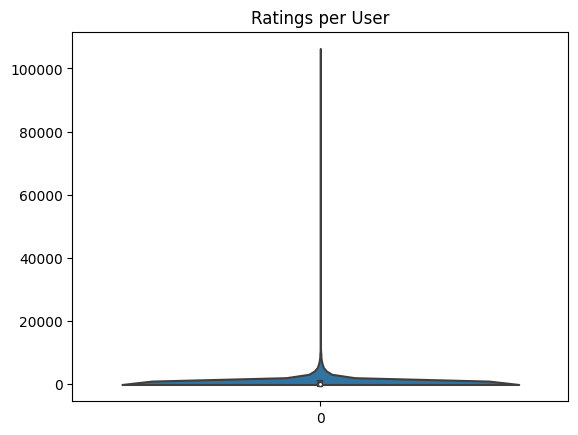

+-------+------------------+-----------------+------------------+------------+
|summary|           user_id|          song_id|            rating|partition_id|
+-------+------------------+-----------------+------------------+------------+
|  count|          76741084|         76741084|          76741084|    76741084|
|   mean| 1700348.749416662|68279.60209738502|3.1597631980283207|         8.0|
| stddev|57598.755727913056| 39464.4027357692|1.6015248563543305|         0.0|
|    min|           1600000|                0|                 1|           8|
|    25%|           1651046|            34380|                 1|           8|
|    50%|           1700132|            68311|                 3|           8|
|    75%|           1750345|           102352|                 5|           8|
|    max|           1799999|           136735|                 5|           8|
+-------+------------------+-----------------+------------------+------------+

Number of unique users:  200000


Number of unique songs:  136736
Number of ratings:  76741084
Ratings per user distribution: 
  summary              count
0   count             200000
1    mean          383.70542
2  stddev  836.0122624789273
3     min                 20
4     max              65140


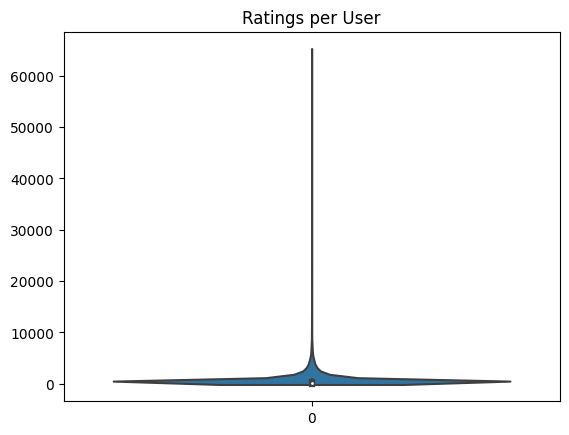

+-------+------------------+-----------------+------------------+------------+
|summary|           user_id|          song_id|            rating|partition_id|
+-------+------------------+-----------------+------------------+------------+
|  count|           8846899|          8846899|           8846899|     8846899|
|   mean|1811553.2431425971| 68288.9593576235| 3.158683963725595|         9.0|
| stddev| 6697.369666133671|39466.73246376229|1.5956257483827654|         0.0|
|    min|           1800000|                0|                 1|           9|
|    25%|           1805722|            34399|                 1|           9|
|    50%|           1811634|            68313|                 3|           9|
|    75%|           1817286|           102371|                 5|           9|
|    max|           1823178|           136735|                 5|           9|
+-------+------------------+-----------------+------------------+------------+

Number of unique users:  23179
Number of unique son

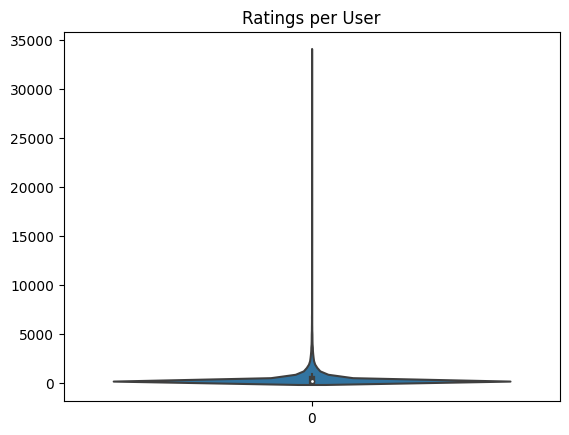

In [175]:
# Combined DF EDA
perform_eda(train_data)

# Partition EDA
for i in range(partitions):
    partition_df = train_data.filter(train_data.partition_id == i)
    perform_eda(partition_df)
    
    


Processing train data partition 0


Processing train data partition 1


Processing train data partition 2


Processing train data partition 3
Processing train data partition 4
Processing train data partition 5


Processing train data partition 6


Processing train data partition 7


Processing train data partition 8
Processing train data partition 9


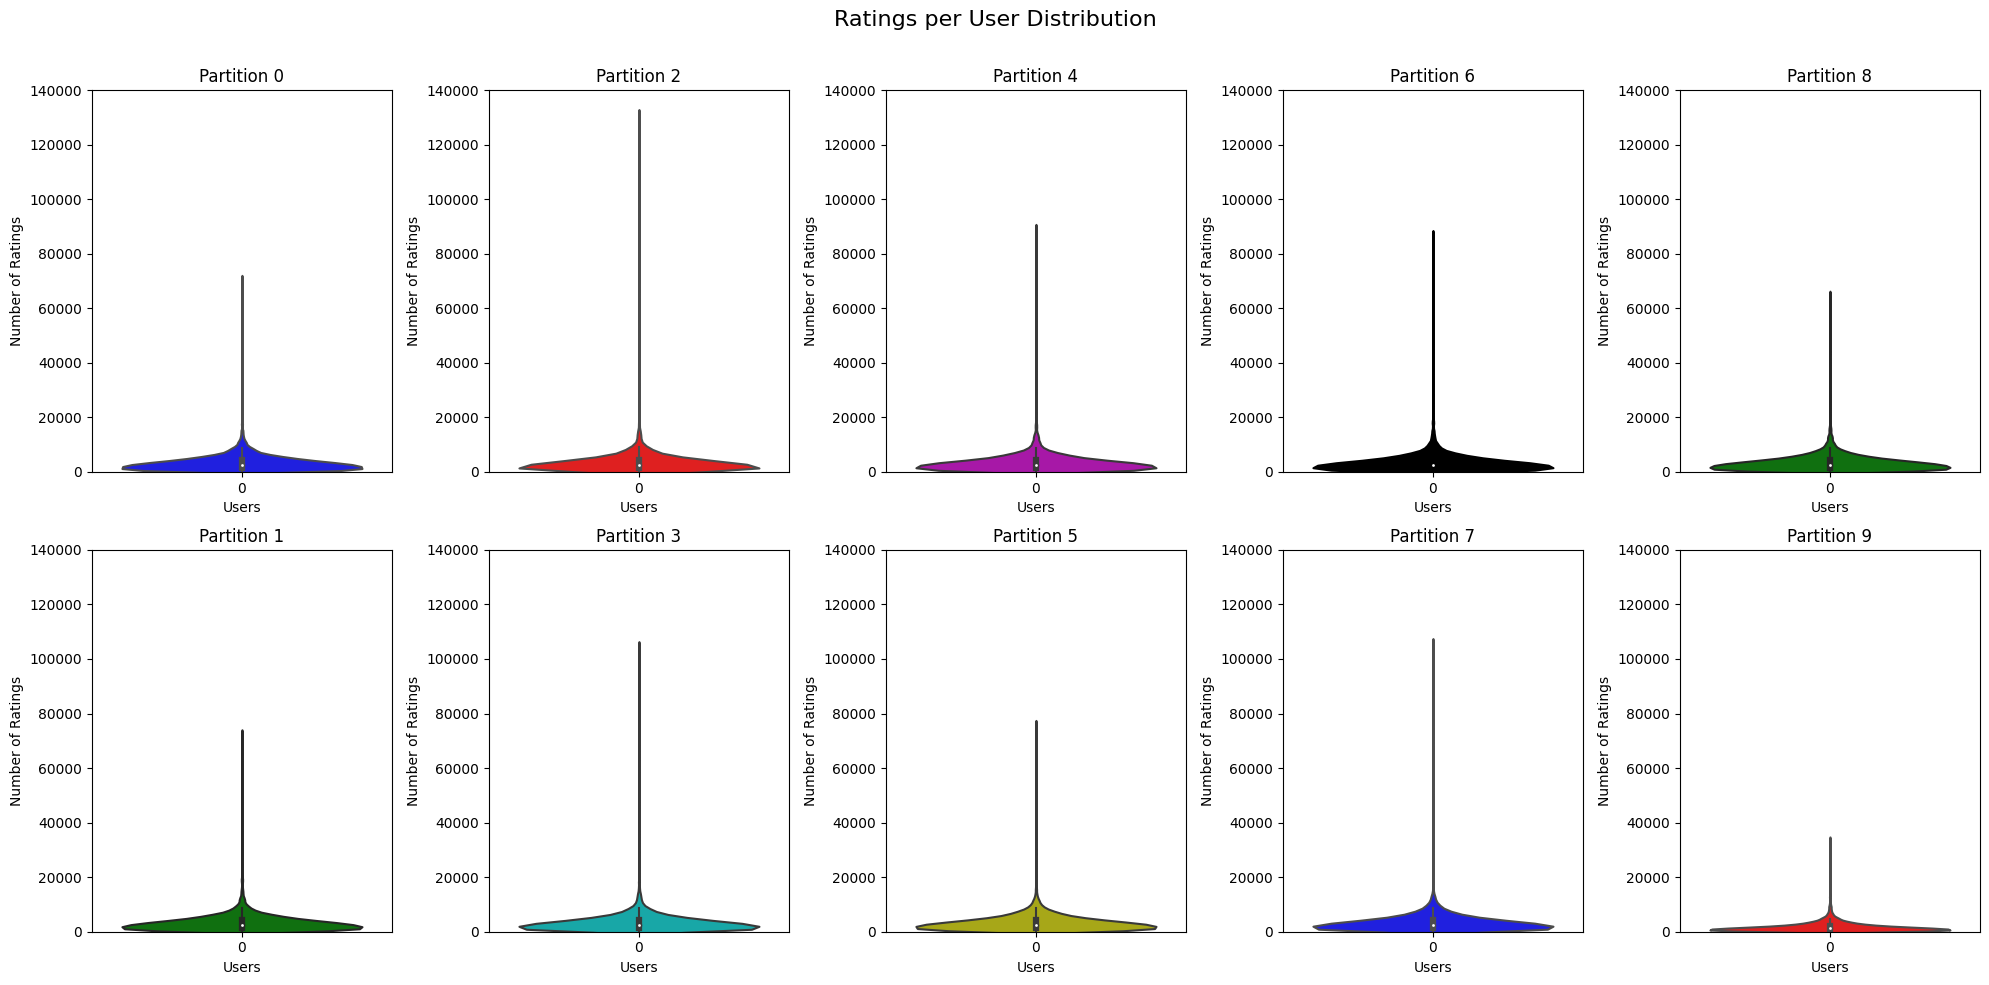

In [172]:
fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(20, 10))
fig.suptitle('Ratings per User Distribution', fontsize=16)
# plt.figure(figsize=(20, 15))

for i in range(10):
    row = i // 2
    col = i % 2
    print(f"Processing train data partition {i}")
    plot_user_ratings_distribution(train_data[i], ax=ax[col, row], partition_id=i)
    # plot_user_ratings_distribution(train_data[i], partition_id=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Test

In [ ]:
# for i in range(len(test_data)):
#     print(f"Processing test data partition {i}")
#     test_data[i] = perform_data_preprocessing(test_data[i])
#     # perform_eda(test_data[i])

In [ ]:
# spark.stop()